In [1]:
import pandas as pd
pd.set_option('display.max_columns', 50)
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import gower
from pyclustering.cluster.kmedoids import kmedoids
from sklearn.metrics import calinski_harabasz_score, silhouette_score
from tqdm import tqdm

In [4]:
df = pd.read_csv('data/clusters.csv').drop('Unnamed: 0', axis=1)
cluster = df[df.cluster==2]
print(cluster.shape)
cluster.head()

(4768, 26)


,artists,name,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,release_date,year,medoid_0,medoid_1,medoid_2,medoid_3,cluster,genre,track_id,artist_id
70,['Cluster'],Hollywood,0.15500,0.844,285933,0.326,0,0.893,1,0.1050,-17.932,1,31,0.0413,130.280,0.509,1974-01-01,1974,0.253272,0.303338,0.217240,0.227692,2,"['ambient', 'art pop', 'art rock', 'berlin sch...",741KQX9BobWT2bV5s5nO2D,5mNY0NPszdalbrb4ITO3M8
323,['LL Cool J'],I Need A Beat (Remix),0.00115,0.809,271600,0.579,0,0.043,1,0.0548,-12.419,1,31,0.3450,176.386,0.917,1985-11-18,1985,0.205410,0.284697,0.192477,0.253160,2,"['east coast hip hop', 'hardcore hip hop', 'hi...",0e23A1EYFRYoj3n7E3OFRQ,1P8IfcNKwrkQP5xJWuhaOC
358,['Kraftwerk'],Boing Boom Tschak - 2009 Remaster,0.04210,0.805,179080,0.896,0,0.810,1,0.0591,-8.893,1,28,0.0605,108.136,0.160,1986,1986,0.224572,0.304600,0.217706,0.259173,2,"['art rock', 'dance rock', 'dusseldorf electro...",4wkbx63HuE9MRq4qakjMwl,0dmPX6ovclgOy8WWJaFEUU
379,['Peter Gabriel'],This Is the Picture (Excellent Birds) - 2012 R...,0.01650,0.820,262547,0.409,0,0.154,1,0.3010,-11.947,1,27,0.0806,91.030,0.736,1986-05-19,1986,0.194098,0.266863,0.190158,0.206595,2,"['album rock', 'art pop', 'art rock', 'classic...",5Yl9XisQ7UOASB0rwhks8d,7C4sUpWGlTy7IANjruj02I
443,['Too $hort'],Oakland,0.00388,0.838,281707,0.362,0,0.901,1,0.1080,-17.253,1,31,0.1180,93.972,0.475,1989-01-31,1989,0.262463,0.322058,0.234222,0.241067,2,"['cali rap', 'gangster rap', 'hip hop', 'hyphy...",6G5u9JjlR02wbPOFHLFsyW,4sb7rZNN93BSS6Gqgepo4v


# Preprocessing #

In [5]:
# create new data frame with only necessary features for modeling
model = cluster.drop(['artists', 'name', 'popularity', 'release_date', 'year', 'medoid_0', 'medoid_1', 'medoid_2', 
                      'medoid_3', 'cluster', 'genre', 'artist_id'], axis=1)
model.set_index('track_id', inplace=True)
print(model.shape)
model.head()

(4768, 13)


,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
track_id,,,,,,,,,,,,,
741KQX9BobWT2bV5s5nO2D,0.15500,0.844,285933,0.326,0,0.893,1,0.1050,-17.932,1,0.0413,130.280,0.509
0e23A1EYFRYoj3n7E3OFRQ,0.00115,0.809,271600,0.579,0,0.043,1,0.0548,-12.419,1,0.3450,176.386,0.917
4wkbx63HuE9MRq4qakjMwl,0.04210,0.805,179080,0.896,0,0.810,1,0.0591,-8.893,1,0.0605,108.136,0.160
5Yl9XisQ7UOASB0rwhks8d,0.01650,0.820,262547,0.409,0,0.154,1,0.3010,-11.947,1,0.0806,91.030,0.736
6G5u9JjlR02wbPOFHLFsyW,0.00388,0.838,281707,0.362,0,0.901,1,0.1080,-17.253,1,0.1180,93.972,0.475


In [6]:
# create list for different types of features for access later
num_features = ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness',
                'speechiness', 'tempo', 'valence']
cat_features = ['explicit', 'mode', 'key']

### Calculate Matrix of Similarities Between All Tracks ###

In [7]:
# create a list of cat_features indicators
cat_ind = [True if x in cat_features else False for x in model.columns]

gdf = gower.gower_matrix(model, cat_features=cat_ind)

In [8]:
gdf_model = pd.DataFrame(gdf, index=model.index)
print(gdf_model.shape)
gdf_model.head()

(4768, 4768)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,4743,4744,4745,4746,4747,4748,4749,4750,4751,4752,4753,4754,4755,4756,4757,4758,4759,4760,4761,4762,4763,4764,4765,4766,4767
track_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
741KQX9BobWT2bV5s5nO2D,0.000000,0.209418,0.150182,0.157057,0.044203,0.377894,0.208459,0.257973,0.416055,0.393793,0.214303,0.333458,0.164861,0.430371,0.513515,0.440101,0.495787,0.435989,0.420718,0.364513,0.182889,0.391234,0.375169,0.395523,0.340065,...,0.381993,0.402659,0.348037,0.382252,0.360422,0.338405,0.345392,0.374815,0.304986,0.323234,0.495272,0.356462,0.201500,0.337180,0.300559,0.183591,0.184121,0.419630,0.451387,0.493588,0.259118,0.375534,0.455207,0.389071,0.208901
0e23A1EYFRYoj3n7E3OFRQ,0.209418,0.000000,0.227670,0.122655,0.204058,0.411358,0.150759,0.219427,0.365955,0.353982,0.061823,0.221103,0.150023,0.334363,0.441925,0.334990,0.351808,0.306317,0.287524,0.296045,0.105717,0.277581,0.283802,0.250430,0.294805,...,0.342706,0.359146,0.353709,0.287678,0.269716,0.262532,0.325688,0.389540,0.214653,0.259867,0.394106,0.291651,0.163809,0.319083,0.186243,0.139245,0.160996,0.329722,0.328798,0.411317,0.172429,0.211677,0.394106,0.326930,0.178020
4wkbx63HuE9MRq4qakjMwl,0.150182,0.227670,0.000000,0.189702,0.136089,0.330206,0.215809,0.246458,0.417813,0.314458,0.236743,0.373867,0.147230,0.363574,0.464193,0.441898,0.459203,0.371979,0.353913,0.317943,0.179721,0.343699,0.318221,0.346838,0.283254,...,0.345987,0.311219,0.334696,0.406056,0.322749,0.347695,0.307490,0.390763,0.232471,0.300449,0.459895,0.326289,0.130262,0.333248,0.247244,0.221252,0.151155,0.448157,0.427758,0.426031,0.258389,0.369391,0.391817,0.306131,0.166519
5Yl9XisQ7UOASB0rwhks8d,0.157057,0.122655,0.189702,0.000000,0.128182,0.346606,0.158005,0.175129,0.329023,0.302993,0.157706,0.241050,0.126801,0.331668,0.445079,0.295057,0.380415,0.334596,0.348786,0.284655,0.081328,0.249959,0.322526,0.279970,0.264981,...,0.295340,0.285389,0.287795,0.322820,0.259336,0.276284,0.300149,0.351240,0.250370,0.245896,0.451188,0.302366,0.122688,0.258318,0.192039,0.141345,0.135800,0.353278,0.368744,0.409693,0.201199,0.278429,0.386457,0.301393,0.150639
6G5u9JjlR02wbPOFHLFsyW,0.044203,0.204058,0.136089,0.128182,0.000000,0.352694,0.239429,0.231339,0.377158,0.386400,0.232475,0.333500,0.176896,0.434711,0.531203,0.410428,0.496208,0.443115,0.410527,0.334606,0.169407,0.364338,0.372965,0.369421,0.328288,...,0.385090,0.371070,0.341871,0.401032,0.351829,0.342563,0.352487,0.400166,0.296475,0.305638,0.507441,0.353143,0.186673,0.330503,0.267982,0.186125,0.187977,0.437984,0.469725,0.463026,0.261397,0.373605,0.435825,0.349572,0.221179


# Modeling #

In [12]:
np.random.seed(2333)

# find k clusters
results_kmedoids1 = dict()

k_cand = range(2, 7)

for k in tqdm(k_cand):
    # initiate k random medoids - sets k clusters
    initial_medoids = np.random.randint(0, 4765,size=k)
    kmedoids_instance = kmedoids(gdf_model, initial_medoids, data_type='distance_matrix')    

    # run cluster analysis and obtain results
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    medoids = kmedoids_instance.get_medoids()

    # convert cluster output
    cluster_array = pd.DataFrame([(x,e) for e,i in enumerate(clusters) for x in i if len(i)>1]).sort_values(by=0)[1].values
    
    # score
    v_ratio = calinski_harabasz_score(gdf_model, cluster_array)
    s_score = silhouette_score(gdf_model, cluster_array)
    
    # store
    results_kmedoids1[k] = {'clusters':cluster_array, 'medoids':medoids, 'v_ratio':v_ratio, 's_score':s_score}

100%|██████████| 5/5 [01:20<00:00, 16.07s/it]


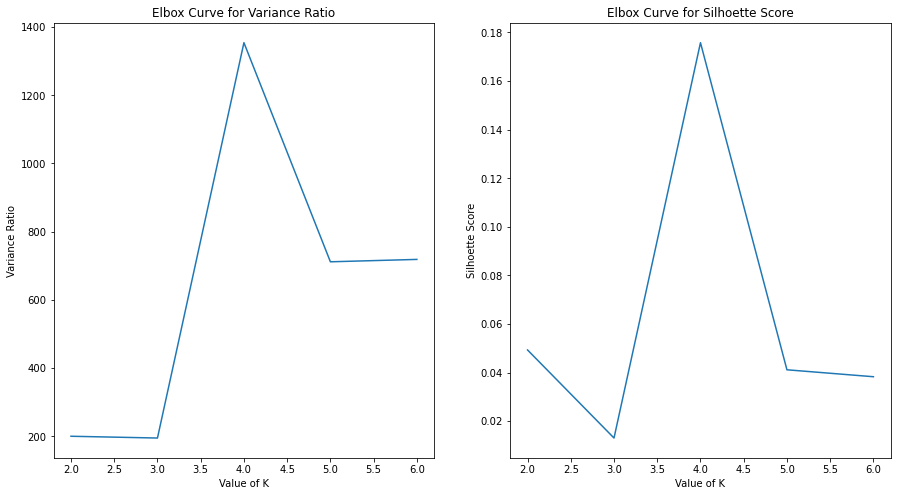

In [13]:
fig, axs = plt.subplots(1,2, figsize=(15,8))

axs[0].plot([i for i in results_kmedoids1.keys()],[i['v_ratio'] for i in results_kmedoids1.values()])
axs[0].set_title('Elbox Curve for Variance Ratio')
axs[0].set_xlabel('Value of K')
axs[0].set_ylabel('Variance Ratio')
axs[1].plot([i for i in results_kmedoids1.keys()],[i['s_score'] for i in results_kmedoids1.values()])
axs[1].set_title('Elbox Curve for Silhoette Score')
axs[1].set_xlabel('Value of K')
axs[1].set_ylabel('Silhoette Score')
plt.show()

In [15]:
# save results for later and use in analysis notebook
results_all = {}
results_all['model1'] = results_kmedoids1

In [16]:
np.random.seed(1141)

# find k clusters
results_kmedoids2 = dict()

k_cand = range(2, 7)

for k in tqdm(k_cand):
    # initiate k random medoids - sets k clusters
    initial_medoids = np.random.randint(0, 4765,size=k)
    kmedoids_instance = kmedoids(gdf_model, initial_medoids, data_type='distance_matrix')    

    # run cluster analysis and obtain results
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    medoids = kmedoids_instance.get_medoids()

    # convert cluster output
    cluster_array = pd.DataFrame([(x,e) for e,i in enumerate(clusters) for x in i if len(i)>1]).sort_values(by=0)[1].values
    
    # score
    v_ratio = calinski_harabasz_score(gdf_model, cluster_array)
    s_score = silhouette_score(gdf_model, cluster_array)
    
    # store
    results_kmedoids2[k] = {'clusters':cluster_array, 'medoids':medoids, 'v_ratio':v_ratio, 's_score':s_score}

100%|██████████| 5/5 [01:15<00:00, 15.02s/it]


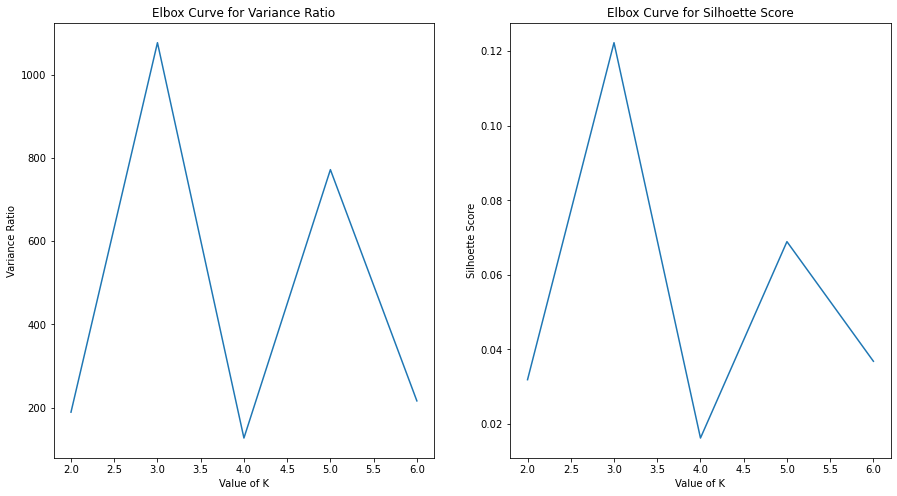

In [17]:
fig, axs = plt.subplots(1,2, figsize=(15,8))

axs[0].plot([i for i in results_kmedoids2.keys()],[i['v_ratio'] for i in results_kmedoids2.values()])
axs[0].set_title('Elbox Curve for Variance Ratio')
axs[0].set_xlabel('Value of K')
axs[0].set_ylabel('Variance Ratio')
axs[1].plot([i for i in results_kmedoids2.keys()],[i['s_score'] for i in results_kmedoids2.values()])
axs[1].set_title('Elbox Curve for Silhoette Score')
axs[1].set_xlabel('Value of K')
axs[1].set_ylabel('Silhoette Score')
plt.show()

In [18]:
# save results for later and use in analysis notebook
results_all['model2'] = results_kmedoids2

In [19]:
np.random.seed(1200)

# find k clusters
results_kmedoids3 = dict()

k_cand = range(2, 7)

for k in tqdm(k_cand):
    # initiate k random medoids - sets k clusters
    initial_medoids = np.random.randint(0, 4765,size=k)
    kmedoids_instance = kmedoids(gdf_model, initial_medoids, data_type='distance_matrix')    

    # run cluster analysis and obtain results
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    medoids = kmedoids_instance.get_medoids()

    # convert cluster output
    cluster_array = pd.DataFrame([(x,e) for e,i in enumerate(clusters) for x in i if len(i)>1]).sort_values(by=0)[1].values
    
    # score
    v_ratio = calinski_harabasz_score(gdf_model, cluster_array)
    s_score = silhouette_score(gdf_model, cluster_array)
    
    # store
    results_kmedoids3[k] = {'clusters':cluster_array, 'medoids':medoids, 'v_ratio':v_ratio, 's_score':s_score}

100%|██████████| 5/5 [01:07<00:00, 13.58s/it]


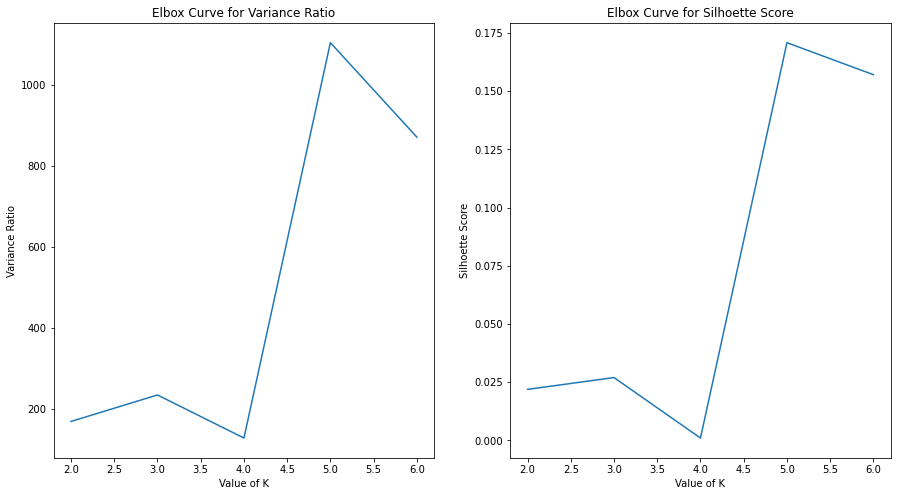

In [20]:
fig, axs = plt.subplots(1,2, figsize=(15,8))

axs[0].plot([i for i in results_kmedoids3.keys()],[i['v_ratio'] for i in results_kmedoids3.values()])
axs[0].set_title('Elbox Curve for Variance Ratio')
axs[0].set_xlabel('Value of K')
axs[0].set_ylabel('Variance Ratio')
axs[1].plot([i for i in results_kmedoids3.keys()],[i['s_score'] for i in results_kmedoids3.values()])
axs[1].set_title('Elbox Curve for Silhoette Score')
axs[1].set_xlabel('Value of K')
axs[1].set_ylabel('Silhoette Score')
plt.show()

In [21]:
# save results for later and use in analysis notebook
results_all['model3'] = results_kmedoids3

In [22]:
np.random.seed(1155)

# find k clusters
results_kmedoids4 = dict()

k_cand = range(2, 7)

for k in tqdm(k_cand):
    # initiate k random medoids - sets k clusters
    initial_medoids = np.random.randint(0, 4765,size=k)
    kmedoids_instance = kmedoids(gdf_model, initial_medoids, data_type='distance_matrix')    

    # run cluster analysis and obtain results
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    medoids = kmedoids_instance.get_medoids()

    # convert cluster output
    cluster_array = pd.DataFrame([(x,e) for e,i in enumerate(clusters) for x in i if len(i)>1]).sort_values(by=0)[1].values
    
    # score
    v_ratio = calinski_harabasz_score(gdf_model, cluster_array)
    s_score = silhouette_score(gdf_model, cluster_array)
    
    # store
    results_kmedoids4[k] = {'clusters':cluster_array, 'medoids':medoids, 'v_ratio':v_ratio, 's_score':s_score}

100%|██████████| 5/5 [01:07<00:00, 13.49s/it]


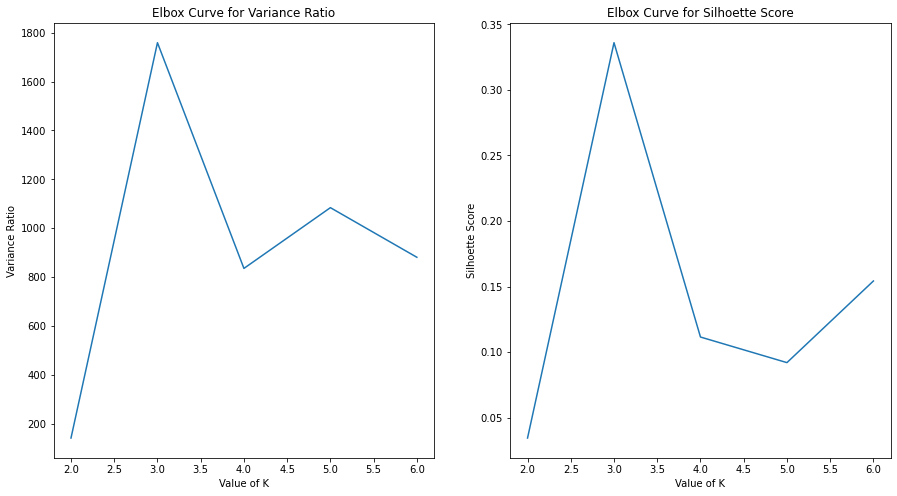

In [23]:
fig, axs = plt.subplots(1,2, figsize=(15,8))

axs[0].plot([i for i in results_kmedoids4.keys()],[i['v_ratio'] for i in results_kmedoids4.values()])
axs[0].set_title('Elbox Curve for Variance Ratio')
axs[0].set_xlabel('Value of K')
axs[0].set_ylabel('Variance Ratio')
axs[1].plot([i for i in results_kmedoids4.keys()],[i['s_score'] for i in results_kmedoids4.values()])
axs[1].set_title('Elbox Curve for Silhoette Score')
axs[1].set_xlabel('Value of K')
axs[1].set_ylabel('Silhoette Score')
plt.show()

In [24]:
# save results for later and use in analysis notebook
results_all['model4'] = results_kmedoids4

Best model so far: k value of 3, variance ratio of 1759.24, and silhoette score of 0.336

In [36]:
np.random.seed(24)

# find k clusters
results_kmedoids5 = dict()

k_cand = range(2, 7)

for k in tqdm(k_cand):
    # initiate k random medoids - sets k clusters
    initial_medoids = np.random.randint(0, 4765,size=k)
    kmedoids_instance = kmedoids(gdf_model, initial_medoids, data_type='distance_matrix')    

    # run cluster analysis and obtain results
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    medoids = kmedoids_instance.get_medoids()

    # convert cluster output
    cluster_array = pd.DataFrame([(x,e) for e,i in enumerate(clusters) for x in i if len(i)>1]).sort_values(by=0)[1].values
    
    # score
    v_ratio = calinski_harabasz_score(gdf_model, cluster_array)
    s_score = silhouette_score(gdf_model, cluster_array)
    
    # store
    results_kmedoids5[k] = {'clusters':cluster_array, 'medoids':medoids, 'v_ratio':v_ratio, 's_score':s_score}

100%|██████████| 5/5 [00:56<00:00, 11.26s/it]


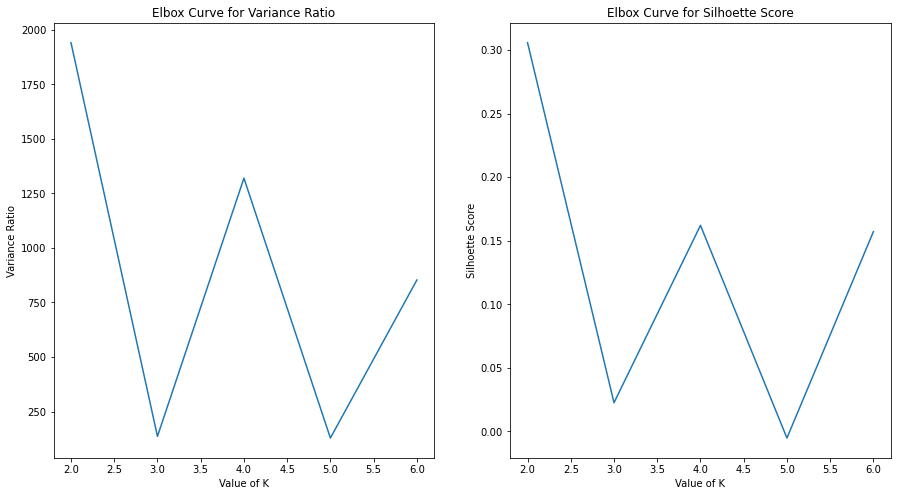

In [37]:
fig, axs = plt.subplots(1,2, figsize=(15,8))

axs[0].plot([i for i in results_kmedoids5.keys()],[i['v_ratio'] for i in results_kmedoids5.values()])
axs[0].set_title('Elbox Curve for Variance Ratio')
axs[0].set_xlabel('Value of K')
axs[0].set_ylabel('Variance Ratio')
axs[1].plot([i for i in results_kmedoids5.keys()],[i['s_score'] for i in results_kmedoids5.values()])
axs[1].set_title('Elbox Curve for Silhoette Score')
axs[1].set_xlabel('Value of K')
axs[1].set_ylabel('Silhoette Score')
plt.show()

In [38]:
# save results for later and use in analysis notebook
results_all['model5'] = results_kmedoids5

This model is also promising. With a k value of 2, it has a higher variance ratio than Model 4 at 1940. Though, the silhoette score is a little lower at .306. This might be worth choosing over Model 4 because it is simpler.

In [39]:
np.random.seed(750)

# find k clusters
results_kmedoids6 = dict()

k_cand = range(2, 7)

for k in tqdm(k_cand):
    # initiate k random medoids - sets k clusters
    initial_medoids = np.random.randint(0, 4765,size=k)
    kmedoids_instance = kmedoids(gdf_model, initial_medoids, data_type='distance_matrix')    

    # run cluster analysis and obtain results
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    medoids = kmedoids_instance.get_medoids()

    # convert cluster output
    cluster_array = pd.DataFrame([(x,e) for e,i in enumerate(clusters) for x in i if len(i)>1]).sort_values(by=0)[1].values
    
    # score
    v_ratio = calinski_harabasz_score(gdf_model, cluster_array)
    s_score = silhouette_score(gdf_model, cluster_array)
    
    # store
    results_kmedoids6[k] = {'clusters':cluster_array, 'medoids':medoids, 'v_ratio':v_ratio, 's_score':s_score}

100%|██████████| 5/5 [01:26<00:00, 17.36s/it]


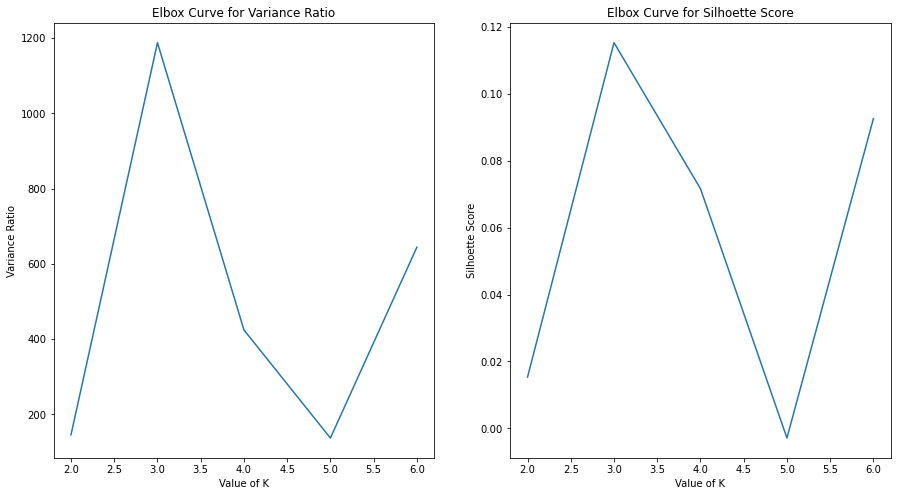

In [40]:
fig, axs = plt.subplots(1,2, figsize=(15,8))

axs[0].plot([i for i in results_kmedoids6.keys()],[i['v_ratio'] for i in results_kmedoids6.values()])
axs[0].set_title('Elbox Curve for Variance Ratio')
axs[0].set_xlabel('Value of K')
axs[0].set_ylabel('Variance Ratio')
axs[1].plot([i for i in results_kmedoids6.keys()],[i['s_score'] for i in results_kmedoids6.values()])
axs[1].set_title('Elbox Curve for Silhoette Score')
axs[1].set_xlabel('Value of K')
axs[1].set_ylabel('Silhoette Score')
plt.show()

In [41]:
# save results for later and use in analysis notebook
results_all['model6'] = results_kmedoids6

In [42]:
np.random.seed(626)

# find k clusters
results_kmedoids7 = dict()

k_cand = range(2, 7)

for k in tqdm(k_cand):
    # initiate k random medoids - sets k clusters
    initial_medoids = np.random.randint(0, 4765,size=k)
    kmedoids_instance = kmedoids(gdf_model, initial_medoids, data_type='distance_matrix')    

    # run cluster analysis and obtain results
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    medoids = kmedoids_instance.get_medoids()

    # convert cluster output
    cluster_array = pd.DataFrame([(x,e) for e,i in enumerate(clusters) for x in i if len(i)>1]).sort_values(by=0)[1].values
    
    # score
    v_ratio = calinski_harabasz_score(gdf_model, cluster_array)
    s_score = silhouette_score(gdf_model, cluster_array)
    
    # store
    results_kmedoids7[k] = {'clusters':cluster_array, 'medoids':medoids, 'v_ratio':v_ratio, 's_score':s_score}

100%|██████████| 5/5 [01:22<00:00, 16.46s/it]


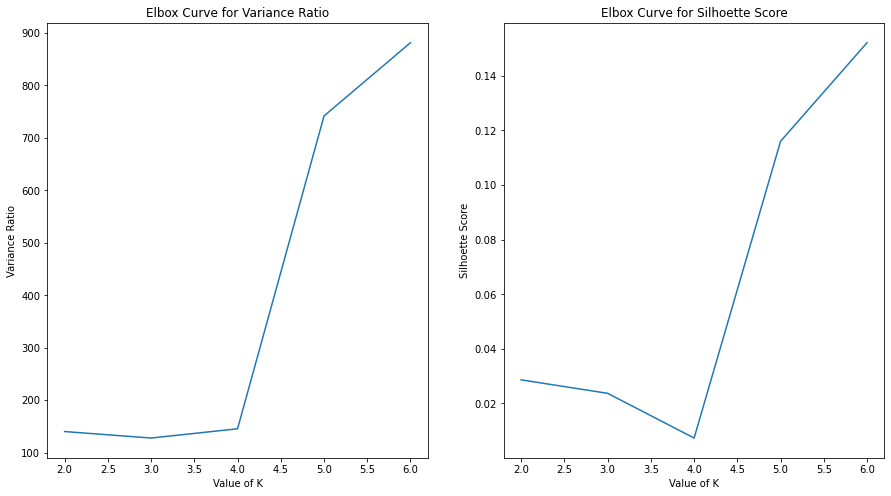

In [43]:
fig, axs = plt.subplots(1,2, figsize=(15,8))

axs[0].plot([i for i in results_kmedoids7.keys()],[i['v_ratio'] for i in results_kmedoids7.values()])
axs[0].set_title('Elbox Curve for Variance Ratio')
axs[0].set_xlabel('Value of K')
axs[0].set_ylabel('Variance Ratio')
axs[1].plot([i for i in results_kmedoids7.keys()],[i['s_score'] for i in results_kmedoids7.values()])
axs[1].set_title('Elbox Curve for Silhoette Score')
axs[1].set_xlabel('Value of K')
axs[1].set_ylabel('Silhoette Score')
plt.show()

In [44]:
# save results for later and use in analysis notebook
results_all['model7'] = results_kmedoids7

In [45]:
np.random.seed(1051)

# find k clusters
results_kmedoids8 = dict()

k_cand = range(2, 7)

for k in tqdm(k_cand):
    # initiate k random medoids - sets k clusters
    initial_medoids = np.random.randint(0, 4765,size=k)
    kmedoids_instance = kmedoids(gdf_model, initial_medoids, data_type='distance_matrix')    

    # run cluster analysis and obtain results
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    medoids = kmedoids_instance.get_medoids()

    # convert cluster output
    cluster_array = pd.DataFrame([(x,e) for e,i in enumerate(clusters) for x in i if len(i)>1]).sort_values(by=0)[1].values
    
    # score
    v_ratio = calinski_harabasz_score(gdf_model, cluster_array)
    s_score = silhouette_score(gdf_model, cluster_array)
    
    # store
    results_kmedoids8[k] = {'clusters':cluster_array, 'medoids':medoids, 'v_ratio':v_ratio, 's_score':s_score}

100%|██████████| 5/5 [01:23<00:00, 16.66s/it]


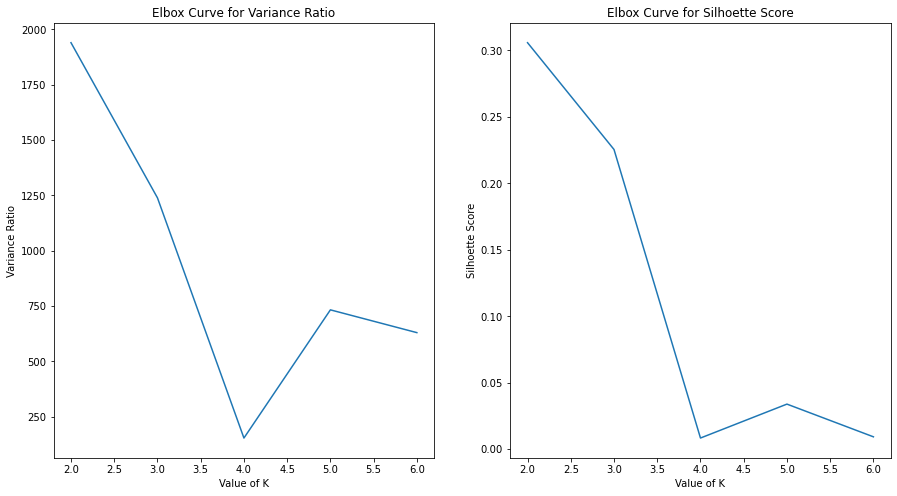

In [46]:
fig, axs = plt.subplots(1,2, figsize=(15,8))

axs[0].plot([i for i in results_kmedoids8.keys()],[i['v_ratio'] for i in results_kmedoids8.values()])
axs[0].set_title('Elbox Curve for Variance Ratio')
axs[0].set_xlabel('Value of K')
axs[0].set_ylabel('Variance Ratio')
axs[1].plot([i for i in results_kmedoids8.keys()],[i['s_score'] for i in results_kmedoids8.values()])
axs[1].set_title('Elbox Curve for Silhoette Score')
axs[1].set_xlabel('Value of K')
axs[1].set_ylabel('Silhoette Score')
plt.show()

While the seed was different, this is the exact same model as Model 5. Same variance ratio, silhoette score, and medoids!

In [47]:
# save results for later and use in analysis notebook
results_all['model8'] = results_kmedoids8

In [48]:
np.random.seed(2258)

# find k clusters
results_kmedoids9 = dict()

k_cand = range(2, 7)

for k in tqdm(k_cand):
    # initiate k random medoids - sets k clusters
    initial_medoids = np.random.randint(0, 4765,size=k)
    kmedoids_instance = kmedoids(gdf_model, initial_medoids, data_type='distance_matrix')    

    # run cluster analysis and obtain results
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    medoids = kmedoids_instance.get_medoids()

    # convert cluster output
    cluster_array = pd.DataFrame([(x,e) for e,i in enumerate(clusters) for x in i if len(i)>1]).sort_values(by=0)[1].values
    
    # score
    v_ratio = calinski_harabasz_score(gdf_model, cluster_array)
    s_score = silhouette_score(gdf_model, cluster_array)
    
    # store
    results_kmedoids9[k] = {'clusters':cluster_array, 'medoids':medoids, 'v_ratio':v_ratio, 's_score':s_score}

100%|██████████| 5/5 [01:17<00:00, 15.52s/it]


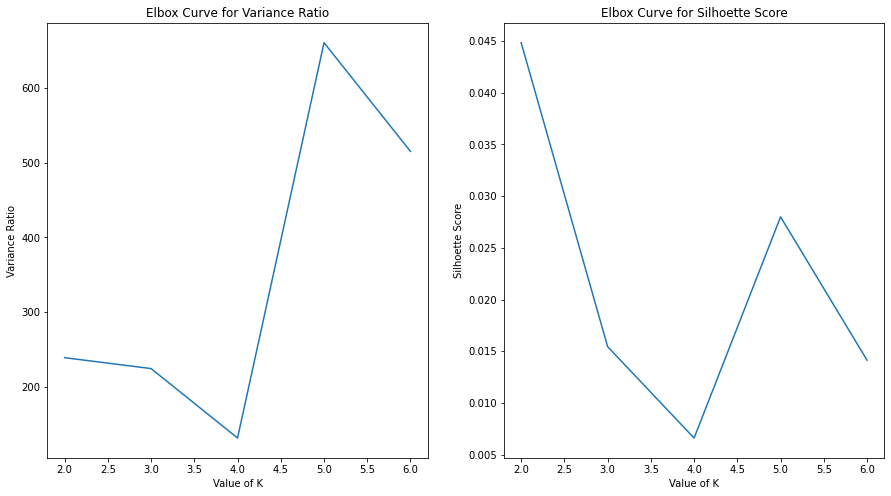

In [49]:
fig, axs = plt.subplots(1,2, figsize=(15,8))

axs[0].plot([i for i in results_kmedoids9.keys()],[i['v_ratio'] for i in results_kmedoids9.values()])
axs[0].set_title('Elbox Curve for Variance Ratio')
axs[0].set_xlabel('Value of K')
axs[0].set_ylabel('Variance Ratio')
axs[1].plot([i for i in results_kmedoids9.keys()],[i['s_score'] for i in results_kmedoids9.values()])
axs[1].set_title('Elbox Curve for Silhoette Score')
axs[1].set_xlabel('Value of K')
axs[1].set_ylabel('Silhoette Score')
plt.show()

In [50]:
# save results for later and use in analysis notebook
results_all['model9'] = results_kmedoids9

In [51]:
np.random.seed(2696)

# find k clusters
results_kmedoids10 = dict()

k_cand = range(2, 7)

for k in tqdm(k_cand):
    # initiate k random medoids - sets k clusters
    initial_medoids = np.random.randint(0, 4765,size=k)
    kmedoids_instance = kmedoids(gdf_model, initial_medoids, data_type='distance_matrix')    

    # run cluster analysis and obtain results
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    medoids = kmedoids_instance.get_medoids()

    # convert cluster output
    cluster_array = pd.DataFrame([(x,e) for e,i in enumerate(clusters) for x in i if len(i)>1]).sort_values(by=0)[1].values
    
    # score
    v_ratio = calinski_harabasz_score(gdf_model, cluster_array)
    s_score = silhouette_score(gdf_model, cluster_array)
    
    # store
    results_kmedoids10[k] = {'clusters':cluster_array, 'medoids':medoids, 'v_ratio':v_ratio, 's_score':s_score}

100%|██████████| 5/5 [01:11<00:00, 14.30s/it]


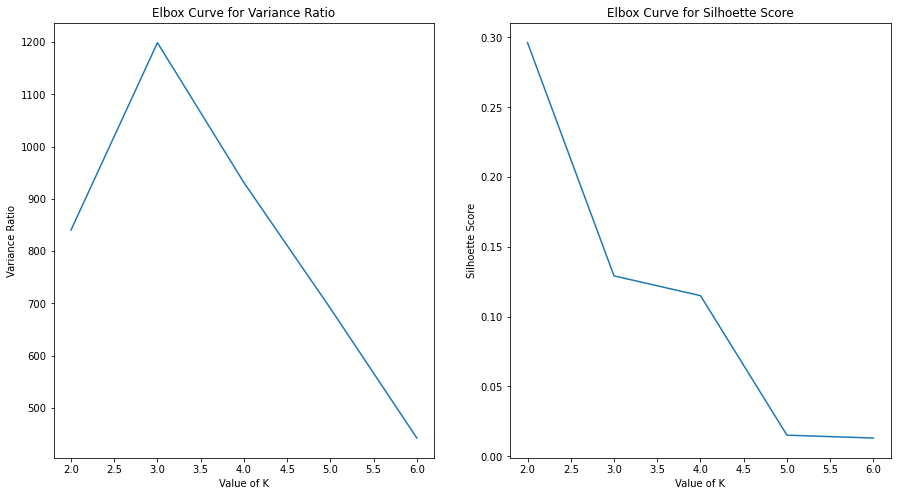

In [52]:
fig, axs = plt.subplots(1,2, figsize=(15,8))

axs[0].plot([i for i in results_kmedoids10.keys()],[i['v_ratio'] for i in results_kmedoids10.values()])
axs[0].set_title('Elbox Curve for Variance Ratio')
axs[0].set_xlabel('Value of K')
axs[0].set_ylabel('Variance Ratio')
axs[1].plot([i for i in results_kmedoids10.keys()],[i['s_score'] for i in results_kmedoids10.values()])
axs[1].set_title('Elbox Curve for Silhoette Score')
axs[1].set_xlabel('Value of K')
axs[1].set_ylabel('Silhoette Score')
plt.show()

In [53]:
# save results for later and use in analysis notebook
results_all['model10'] = results_kmedoids10

# Conclusions #

Both Model 4 and 5 produced the best results. Model 4 had a higher silhoette score (.336 vs .306) while Model 5 had a higher variance ratio (1940.3 vs 1759.24). Model 4 used three medoids while Model 5 used two. Below we see which produce the most distict groups.

In [66]:
results_all['model4'][3]

{'clusters': array([1, 1, 1, ..., 2, 0, 1]),
 'medoids': [3226, 4373, 2194],
 'v_ratio': 1759.2411559606178,
 's_score': 0.33604467}

In [67]:
results_all['model5'][2]

{'clusters': array([1, 1, 1, ..., 0, 1, 1]),
 'medoids': [2194, 3226],
 'v_ratio': 1940.3557710441353,
 's_score': 0.30584782}

Interestingly, they have two medoids in common. Does the third one lead to more distinct groups?

In [132]:
# medoids for each subcluster
cluster.iloc[[3226, 4373, 2194]]

,artists,name,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,release_date,year,medoid_0,medoid_1,medoid_2,medoid_3,cluster,genre,track_id,artist_id
25321,['Big Sean'],Jump Out The Window,0.1360,0.747,213693,0.704,1,0.000000,1,0.131,-6.743,1,67,0.0986,136.936,0.494,2017-02-03,2017,0.209933,0.272426,0.000000,0.254071,2,"['detroit hip hop', 'hip hop', 'pop rap', 'rap...",1jQsKN68yE94tMYml0wHMd,0c173mlxpT3dSFRgMO8XPh
33985,['Marques Houston'],Circle,0.1060,0.676,245027,0.662,0,0.000000,1,0.122,-6.438,1,51,0.0442,127.999,0.464,2007-01-01,2007,0.122351,0.184328,0.100831,0.160324,2,"['hip pop', 'new jack swing', 'pop r&b', 'pop ...",4awnQTwynhz0j6Rk2ZwM6A,1goOx6gnQdUllLfSMsL4Rt
19013,"['Chris Brown', 'Lil Wayne', 'Busta Rhymes']",Look At Me Now,0.0339,0.767,222587,0.677,1,0.000006,11,0.144,-6.128,0,73,0.1840,146.155,0.538,2011-03-22,2011,0.292978,0.212363,0.182061,0.355050,2,"['dance pop', 'pop', 'pop rap', 'r&b', 'rap']",3hsmbFKT5Cujb5GQjqEU39,7bXgB6jMjp9ATFy66eO08Z


In [154]:
medoids = gdf_model.iloc[[3226, 4373, 2194]].T
medoids['cluster2'] = results_all['model4'][3]['clusters']
medoids.columns = ['medoid2_0', 'medoid2_1', 'medoid2_2', 'subcluster']
medoids.index = cluster.track_id

In [155]:
temp = cluster.set_index('track_id')
temp = temp.merge(medoids, left_index=True, right_index=True)

In [157]:
temp[temp.subcluster==0].sort_values('medoid2_0').head()

,artists,name,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,release_date,year,medoid_0,medoid_1,medoid_2,medoid_3,cluster,genre,artist_id,medoid2_0,medoid2_1,medoid2_2,subcluster
track_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1jQsKN68yE94tMYml0wHMd,['Big Sean'],Jump Out The Window,0.1360,0.747,213693,0.704,1,0.0,1,0.1310,-6.743,1,67,0.0986,136.936,0.494,2017-02-03,2017,0.209933,0.272426,0.000000,0.254071,2,"['detroit hip hop', 'hip hop', 'pop rap', 'rap...",0c173mlxpT3dSFRgMO8XPh,0.000000,0.104400,0.184815,0
2FSQYGTyk8GTIaiRyAWu74,"['Fabolous', 'T-Pain']",Baby Don't Go,0.0885,0.834,216653,0.687,1,0.0,1,0.1440,-6.473,1,46,0.1050,99.752,0.491,2007-01-01,2007,0.220592,0.282441,0.030164,0.262602,2,"['dance pop', 'gangster rap', 'hip hop', 'hip ...",0YWxKQj2Go9CGHCp77UOyy,0.032230,0.118496,0.197582,0
3aHkbJXFYpPrup2K8wvDOV,"['B.o.B', 'T.I.', 'Juicy J']",We Still in this Bitch (feat. T.I. and Juicy J),0.0130,0.693,247987,0.733,1,0.0,1,0.0924,-5.126,1,55,0.1390,140.010,0.497,2013-12-16,2013,0.203361,0.284753,0.027749,0.269404,2,"['atl hip hop', 'dance pop', 'hip hop', 'pop',...",5ndkK3dpZLKtBklKjxNQwT,0.033319,0.115159,0.186397,0
10sNkTjcPhK9A112WCMIbv,['Rittz'],Turn Down,0.1390,0.763,251693,0.751,1,0.0,1,0.2430,-7.877,1,51,0.1450,127.995,0.556,2014-09-09,2014,0.214719,0.279804,0.029142,0.271082,2,"['atl hip hop', 'country rap', 'pop rap', 'sou...",5sRhscbWRXFbjXtSZyfaWY,0.034381,0.126556,0.197649,0
4w27lZ9zcceZp6rumzGCBx,"['Wale', 'Kid Cudi']",Focused (feat. Kid Cudi),0.2750,0.735,212333,0.801,1,0.0,1,0.1370,-5.067,1,43,0.0554,123.094,0.497,2011-10-28,2011,0.206087,0.269876,0.032347,0.244205,2,"['dance pop', 'gangster rap', 'hip hop', 'pop'...",67nwj3Y5sZQLl72VNUHEYE,0.036676,0.121404,0.215703,0


In [158]:
temp[temp.subcluster==1].sort_values('medoid2_1').head()

,artists,name,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,release_date,year,medoid_0,medoid_1,medoid_2,medoid_3,cluster,genre,artist_id,medoid2_0,medoid2_1,medoid2_2,subcluster
track_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4awnQTwynhz0j6Rk2ZwM6A,['Marques Houston'],Circle,0.106,0.676,245027,0.662,0,0.000000,1,0.1220,-6.438,1,51,0.0442,127.999,0.464,2007-01-01,2007,0.122351,0.184328,0.100831,0.160324,2,"['hip pop', 'new jack swing', 'pop r&b', 'pop ...",1goOx6gnQdUllLfSMsL4Rt,0.104400,0.000000,0.276546,1
12tUCBq7V9qCF8qGOLpcnu,['Maroon 5'],Love Somebody,0.129,0.675,229827,0.790,0,0.000000,1,0.1210,-6.295,1,57,0.0369,120.015,0.423,2012-01-01,2012,0.116980,0.191979,0.109669,0.161056,2,"['pop', 'pop rock']",04gDigrS5kc9YWfZHwBETP,0.113373,0.021846,0.292675,1
0HnaqUxvHP5LaWdmWwJpiS,['Maroon 5'],Love Somebody,0.145,0.675,229813,0.792,0,0.000000,1,0.1200,-6.303,1,60,0.0368,120.016,0.395,2012-01-01,2012,0.120483,0.192983,0.112217,0.157705,2,"['pop', 'pop rock']",04gDigrS5kc9YWfZHwBETP,0.116031,0.025596,0.296479,1
4JAi20NP5hkUpaKvwtX1nO,['Roxette'],Vulnerable,0.121,0.553,300973,0.658,0,0.000244,1,0.0969,-5.862,1,52,0.0273,134.004,0.444,1994-04-11,1994,0.118453,0.193761,0.114842,0.162180,2,"['dance pop', 'europop', 'new wave pop', 'pop ...",2SHhfs4BiDxGQ3oxqf0UHY,0.123315,0.026468,0.295610,1
5xJII9WBtF4YwKeTsymO6P,['Relient K'],Savannah,0.143,0.702,256720,0.695,0,0.000032,1,0.1150,-6.152,1,43,0.0352,107.915,0.554,2009-10-05,2009,0.122542,0.177626,0.107166,0.166028,2,"['canadian ccm', 'christian alternative rock',...",3nJWBJvK7uGvfp4iZh9CkN,0.111797,0.027273,0.282512,1


In [159]:
temp[temp.subcluster==2].sort_values('medoid2_2').head()

,artists,name,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,release_date,year,medoid_0,medoid_1,medoid_2,medoid_3,cluster,genre,artist_id,medoid2_0,medoid2_1,medoid2_2,subcluster
track_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3hsmbFKT5Cujb5GQjqEU39,"['Chris Brown', 'Lil Wayne', 'Busta Rhymes']",Look At Me Now,0.03390,0.767,222587,0.677,1,0.000006,11,0.1440,-6.128,0,73,0.184,146.155,0.538,2011-03-22,2011,0.292978,0.212363,0.182061,0.355050,2,"['dance pop', 'pop', 'pop rap', 'r&b', 'rap']",7bXgB6jMjp9ATFy66eO08Z,0.184815,0.276546,0.000000,2
63XXvHR6FfiRDk5lKNNCMI,"['Hurricane Chris', 'Superstarr']",Halle Berry (She's Fine) (feat. Superstarr),0.01190,0.709,281480,0.744,1,0.000000,11,0.0609,-5.905,0,49,0.134,145.112,0.508,2009-12-18,2009,0.283475,0.212715,0.185521,0.352916,2,"['deep southern trap', 'dirty south rap', 'gan...",1fQ46lgoUCz8FVXdTVNk0a,0.191574,0.276327,0.031617,2
62x93blgkWEz6Huop8eSQA,"['Lil Wyte', 'Jelly Roll']",Band Plays On,0.00282,0.802,221053,0.794,1,0.000000,11,0.0927,-5.054,0,61,0.196,152.571,0.633,2013-07-16,2013,0.284994,0.231905,0.207166,0.380886,2,"['country rap', 'crunk', 'dirty south rap', 'g...",21O7WwRkik43ErKppxDKJq,0.213028,0.308111,0.035110,2
49zD0wr2S3d0lZPib0K4e1,['Future'],F*ck Up Some Commas,0.06980,0.874,237400,0.568,1,0.000014,11,0.1490,-5.896,0,67,0.224,139.995,0.460,2015-07-17,2015,0.318214,0.232878,0.197622,0.348554,2,"['atl hip hop', 'pop rap', 'rap', 'southern hi...",1RyvyyTE3xzB2ZywiAwp0i,0.203303,0.285511,0.036572,2
4JPCdSaqs9dJd7RatFSHww,"['Fat Joe', 'Lil Wayne']",Make It Rain,0.01060,0.744,247413,0.697,1,0.000000,11,0.0842,-5.063,0,59,0.197,149.280,0.767,2006-11-14,2006,0.293297,0.228467,0.206131,0.378274,2,"['bronx hip hop', 'east coast hip hop', 'gangs...",3ScY9CQxNLQei8Umvpx5g6,0.212705,0.302642,0.037021,2


In [162]:
temp.subcluster.value_counts(normalize=True)

0    0.636745
2    0.280621
1    0.082634
Name: subcluster, dtype: float64

The Original Cluster 2 was already very distinct before it was further divided. That being said, adding three more subclusters captures more differences. Subcluster 1, while small, captures a very distinct set of tracks that were present in the original cluster and makes it more distinct.

In [161]:
# export csv file
temp.to_csv('data/cluster2_subclusters.csv')